In [2]:
!nvidia-smi

Mon Jul  5 16:59:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
zip_path = "/content/drive/My Drive/Colab Notebooks/SeminarskiB-NN/CelebaHQ_org.zip"
!cp "{zip_path}" .
!unzip -q "CelebaHQ_org.zip"
!rm "CelebaHQ_org.zip"

In [5]:
import os,shutil
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras
import matplotlib.pyplot as plt
import numpy as np

import cv2
from tqdm import tqdm

from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Conv2D, Dense, \
                         Flatten, Add, PReLU, Conv2DTranspose, Lambda, UpSampling2D                    
from keras.optimizers import Adam
from tensorflow.keras.applications import VGG19
from keras.callbacks import ReduceLROnPlateau


# Load the TensorBoard notebook extension
%load_ext tensorboard

print("Setup complete!")

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Setup complete!


In [6]:

class LoadDataset:
    def __init__(self, relative_path, validation_split = None, image_size_large = 256, image_size_small = 64, batch_size = 16, shuffle = True, interpolation = "bilinear"):
        print(relative_path)
        self.path = os.path.join("CelebaHQ", relative_path)
        self.image_size_large = image_size_large
        self.image_size_small = image_size_small
        self.batch_size = batch_size
        self.validation_split = validation_split
        self.interpolation = interpolation
        self.shuffle = shuffle
        self.seed = 1337

        self.hr_images_train = None
        self.hr_images_valid = None
        self.lr_images_train = None
        self.lr_images_valid = None

        self.hr_images_train = self.generate(self.image_size_large, "training" if self.validation_split != None else None)
        self.lr_images_train = self.generate(self.image_size_small, "training" if self.validation_split != None else None)
        self.hr_images_train = self.hr_images_train.prefetch(buffer_size=self.batch_size)
        self.lr_images_train = self.lr_images_train.prefetch(buffer_size=self.batch_size)

        if self.validation_split != None:
            self.hr_images_valid = self.generate(self.image_size_large, "validation" if self.validation_split != None else None)
            self.lr_images_valid = self.generate(self.image_size_small, "validation" if self.validation_split != None else None)
            self.hr_images_valid = self.hr_images_valid.prefetch(buffer_size=self.batch_size)
            self.lr_images_valid = self.lr_images_valid.prefetch(buffer_size=self.batch_size)

        
    def generate(self, image_size, subset):
        return tf.keras.preprocessing.image_dataset_from_directory(
            self.path,
            labels="inferred",
            label_mode=None,
            class_names=None,
            color_mode="rgb",
            batch_size=self.batch_size,
            image_size=(image_size, image_size),
            shuffle=self.shuffle,
            seed=self.seed,
            validation_split=self.validation_split,
            subset=subset,
            interpolation=self.interpolation,
            follow_links=False,
        )


In [8]:
train_set_size = 28000
valid_set_size = 1900
test_set_size = 100
batch_size = 32
train_valid_dataset = LoadDataset("train_valid_set", validation_split=valid_set_size/(train_set_size + valid_set_size), batch_size=batch_size)
test_dataset = LoadDataset("test_set",batch_size=batch_size, shuffle=False)

train_valid_set
Found 29900 files belonging to 1 classes.
Using 28000 files for training.
Found 29900 files belonging to 1 classes.
Using 28000 files for training.
Found 29900 files belonging to 1 classes.
Using 1900 files for validation.
Found 29900 files belonging to 1 classes.
Using 1900 files for validation.
test_set
Found 100 files belonging to 1 classes.
Found 100 files belonging to 1 classes.


In [9]:
import os,shutil
import cv2
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Conv2D, Dense, \
                         Flatten, Add, PReLU, Conv2DTranspose, Lambda, UpSampling2D                    
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

class SRResNet:
    def __init__(self):
        self.upscale_factor = 4
        self.model = self.build((64, 64, 3))

    def SubpixelConv2D(self,scale):
        return Lambda(lambda x: tf.nn.depth_to_space(x, scale))


    def res_block(self, input_layer):
        x = Conv2D(filters=64, kernel_size=3, strides=1, padding="same")(input_layer)
        x = BatchNormalization(momentum=0.8)(x)
        x = PReLU()(x)
        x = Conv2D(filters=64, kernel_size=3, strides=1, padding="same")(x)
        x = BatchNormalization(momentum=0.8)(x)
        return Add()([input_layer, x])

    def upsample_block(self, input_layer):
        x = Conv2D(filters=256, kernel_size=3, strides=1, padding="same")(input_layer)
        x = self.SubpixelConv2D(2)(x)
        return PReLU()(x)

    def build(self, input_shape, res_blocks = 8):
        inputs = keras.Input(shape=input_shape)
        x = tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)

        x = Conv2D(filters=64, kernel_size=9, padding="same")(x)
        x = PReLU()(x)
        output1 = x

        for _ in range(res_blocks):
            x = self.res_block(x)

        x = Conv2D(filters=64, kernel_size=3, strides=1, padding="same")(x)
        output2 = BatchNormalization(momentum=0.8)(x)
        x = Add()([output1, output2])

        for _ in range(self.upscale_factor // 2):
            x = self.upsample_block(x)

        outputs = Conv2D(filters=3, kernel_size=9, strides=1, padding="same", activation="tanh")(x)
        
        model = Model(inputs=inputs, outputs=outputs)
        model.compile(
          optimizer=keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.9,beta_2=0.999),
          loss="mse",
          loss_weights=1
        )
        
        return model



class SRValidator:
  def __init__(self):
        self.upscale_factor = 4
        self.model = self.build((256,256,3))
  
  def disc_block(self, input, n_filters, batch_norm):
    x = Conv2D(filters = n_filters, kernel_size = 3, padding = 'same')(input)
    if batch_norm:
        x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(filters = n_filters, kernel_size = 3,
                strides=2, padding = 'same')(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

  def build(self, input_shape, blocks_num=4):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for i in range(blocks_num):
      x = self.disc_block(x, (2 ** i) * 64, False if i == 0 else True)
    x = Flatten()(x)
    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.2)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.9,beta_2=0.999),
        loss="binary_crossentropy",
        loss_weights=1,
        metrics=['accuracy']
    )

    return model
    



In [ ]:
validator = SRValidator()
validator.model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 64)      256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     73856 

In [10]:
model = keras.models.load_model("/content/drive/My Drive/Colab Notebooks/SeminarskiB-NN/logs/srresnet/20210517-182937/model_checkpoints/epoch_29")

(64, 256, 256, 3)


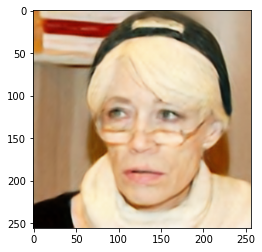

In [ ]:
train_dataset = tf.data.Dataset.zip((train_valid_dataset.lr_images_train, train_valid_dataset.hr_images_train.map(lambda x: x / 127.5 - 1.0)))
valid_dataset = tf.data.Dataset.zip((train_valid_dataset.lr_images_valid, train_valid_dataset.hr_images_valid.map(lambda x: x / 127.5 - 1.0)))
dataset_batch = test_dataset.lr_images_train.take(1)
for batch in dataset_batch:
  generated_batch = model.predict_on_batch(batch)
  print(generated_batch.shape)
  plt.imshow((generated_batch[0] + 1) / 2.0)

In [ ]:
def train_validator(dataset, epochs, generator, model=None):
  train_dataset = tf.data.Dataset.zip((dataset.lr_images_train, dataset.hr_images_train.map(lambda x: x / 127.5 - 1.0)))
  valid_dataset = tf.data.Dataset.zip((dataset.lr_images_valid, dataset.hr_images_valid.map(lambda x: x / 127.5 - 1.0)))
  if model == None:
    validator = SRValidator().model
  else:
    validator = model
  
  tensorboard_images_num = 2

  current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  save_dir = "/content/drive/My Drive/Colab Notebooks/SeminarskiB-NN/logs/srvalidator/" + current_time
  train_log_dir = save_dir + "/tensorboard_train"
  save_model_dir = save_dir + "/model_checkpoints"
  charts_dir = save_dir + "/charts"
  !mkdir "$save_dir"
  !mkdir "$save_model_dir"
  !mkdir "$charts_dir"
  train_summary_writer = tf.summary.create_file_writer(train_log_dir) 

  total_iterations = train_set_size // dataset.batch_size
  train_losses = []
  valid_losses = []
  step = 0

  for epoch in range(epochs):
    for i, (lr_batch_train, hr_batch_train) in tqdm(enumerate(train_dataset), total=total_iterations, desc=f"Epoch: {epoch}", unit="batches"):
      generated_images = generator.predict_on_batch(lr_batch_train)
      
      real_loss, real_acc = validator.train_on_batch(hr_batch_train,y=tf.ones([batch_size, 1]))
      fake_loss, fake_acc = validator.train_on_batch(generated_images,y=tf.zeros([batch_size, 1]))

      check_real_loss, check_real_acc = validator.test_on_batch(hr_batch_train,y=tf.ones([batch_size, 1]))
      check_fake_loss, check_fake_acc = validator.test_on_batch(generated_images,y=tf.zeros([batch_size, 1]))

      if i % 10 == 0:
        print(f"Batch {i}")
        print(f"Real loss: {real_loss}")
        print(f"Real acc: {real_acc}")
        print(f"Fake loss: {fake_loss}")
        print(f"Fake acc: {fake_acc}")
        print(f"Real check loss: {check_real_loss}")
        print(f"Real check acc: {check_real_acc}")
        print(f"Fake check loss: {check_fake_loss}")
        print(f"Fake check acc: {check_fake_acc}")


      #if step % 50 == 0:
        #train_losses.append(loss)
        #valid_batch = valid_dataset.take(1)
        #valid_loss = generator.evaluate(x=valid_batch, verbose=0)
        #valid_losses.append(valid_loss)
          
        #with train_summary_writer.as_default():
          #tf.summary.scalar('train_loss',gen_loss,step=step)
          #tf.summary.image('train_input_images', lr_batch_train.numpy().astype("uint8")[0:tensorboard_images_num], step=step)
          #tf.summary.image('train_genarated_images',((1 + generator(lr_batch_train,training=False).numpy()) * 127.5).astype("uint8")[0:tensorboard_images_num] ,step=step)
          #tf.summary.image('train_real_images',hr_batch_train.numpy().astype("uint8")[0:tensorboard_images_num],step=step)
          #tf.summary.scalar('valid_loss',valid_loss,step=step)
         
      step += 1

    validator.save(save_model_dir + f"/epoch_{epoch}")
    #plot_losses(train_losses, valid_losses,"Train - Valid Loss","steps","loss","train loss", "valid_loss", charts_dir + f"/train_loss_after_epoch_{epoch}")


In [ ]:
train_validator(train_valid_dataset, 1, model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Batch 0
Real loss: 0.43530622124671936
Real acc: 0.828125
Fake loss: 208.23292541503906
Fake acc: 0.0
Real check loss: 5.961275746813044e-06
Real check acc: 1.0
Fake check loss: 12.029666900634766
Fake check acc: 0.0
Batch 10
Real loss: 1.3623292446136475
Real acc: 0.6875
Fake loss: 2.4478092193603516
Fake acc: 0.25
Real check loss: 0.4068758487701416
Real check acc: 0.921875
Fake check loss: 2.6412410736083984
Fake check acc: 0.078125
Batch 20
Real loss: 2.314283609390259
Real acc: 0.484375
Fake loss: 1.787729024887085
Fake acc: 0.1875
Real check loss: 1.0396932363510132
Real check acc: 0.671875
Fake check loss: 0.9013606905937195
Fake check acc: 0.5625
Batch 30
Real loss: 1.7537810802459717
Real acc: 0.484375
Fake loss: 1.861547827720642
Fake acc: 0.609375
Real check loss: 1.353423833847046
Real check acc: 0.328125
Fake check loss: 0.19985653460025787
Fake check acc: 0.96875
Batch 40
Real loss: 0.7427582740783691
Real acc: 0.671875
Fake loss: 1.5235010385513306
Fake acc: 0.5625
Real 

ValueError: ignored

In [1]:
import os,shutil
import cv2
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Conv2D, Dense, \
                         Flatten, Add, PReLU, Conv2DTranspose, Lambda, UpSampling2D                    
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

class SRValidator2:
  def __init__(self):
        self.upscale_factor = 4
        self.model = self.build((256,256,3))
  
  def disc_block(self, input, n_filters, batch_norm):
    x = Conv2D(filters = n_filters, kernel_size = 3, padding = 'same')(input)
    if batch_norm:
        x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(filters = n_filters, kernel_size = 3,
                strides=2, padding = 'same')(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

  def build(self, input_shape, blocks_num=4):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for i in range(blocks_num):
      x = self.disc_block(x, (2 ** i) * 64, False if i == 0 else True)
    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.2)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.9,beta_2=0.999),
        loss="binary_crossentropy",
        loss_weights=1,
        metrics=['accuracy']
    )

    return model
    


In [12]:
validator2 = SRValidator2()
validator2.model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_7 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 128, 128, 128)     7385

In [16]:
def train_validator2(dataset, epochs, generator, model=None):
  train_dataset = tf.data.Dataset.zip((dataset.lr_images_train, dataset.hr_images_train.map(lambda x: x / 127.5 - 1.0)))
  valid_dataset = tf.data.Dataset.zip((dataset.lr_images_valid, dataset.hr_images_valid.map(lambda x: x / 127.5 - 1.0)))
  if model == None:
    validator = SRValidator2().model
  else:
    validator = model
  
  tensorboard_images_num = 2

  current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  save_dir = "/content/drive/My Drive/Colab Notebooks/SeminarskiB-NN/logs/srvalidator/" + current_time
  train_log_dir = save_dir + "/tensorboard_train"
  save_model_dir = save_dir + "/model_checkpoints"
  charts_dir = save_dir + "/charts"
  !mkdir "$save_dir"
  !mkdir "$save_model_dir"
  !mkdir "$charts_dir"
  train_summary_writer = tf.summary.create_file_writer(train_log_dir) 

  total_iterations = train_set_size // dataset.batch_size
  train_losses = []
  valid_losses = []
  step = 0

  for epoch in range(epochs):
    for i, (lr_batch_train, hr_batch_train) in tqdm(enumerate(train_dataset), total=total_iterations, desc=f"Epoch: {epoch}", unit="batches"):
      generated_images = generator.predict_on_batch(lr_batch_train)
      
      real_loss, real_acc = validator.train_on_batch(hr_batch_train,y=tf.ones([batch_size, 16, 16, 1]))
      fake_loss, fake_acc = validator.train_on_batch(generated_images,y=tf.zeros([batch_size, 16, 16, 1]))

      check_real_loss, check_real_acc = validator.test_on_batch(hr_batch_train,y=tf.ones([batch_size, 16, 16, 1]))
      check_fake_loss, check_fake_acc = validator.test_on_batch(generated_images,y=tf.zeros([batch_size, 16, 16, 1]))

      if i % 10 == 0:
        print(f"Batch {i}")
        print(f"Real loss: {real_loss}")
        print(f"Real acc: {real_acc}")
        print(f"Fake loss: {fake_loss}")
        print(f"Fake acc: {fake_acc}")
        print(f"Real check loss: {check_real_loss}")
        print(f"Real check acc: {check_real_acc}")
        print(f"Fake check loss: {check_fake_loss}")
        print(f"Fake check acc: {check_fake_acc}")


      #if step % 50 == 0:
        #train_losses.append(loss)
        #valid_batch = valid_dataset.take(1)
        #valid_loss = generator.evaluate(x=valid_batch, verbose=0)
        #valid_losses.append(valid_loss)
          
        #with train_summary_writer.as_default():
          #tf.summary.scalar('train_loss',gen_loss,step=step)
          #tf.summary.image('train_input_images', lr_batch_train.numpy().astype("uint8")[0:tensorboard_images_num], step=step)
          #tf.summary.image('train_genarated_images',((1 + generator(lr_batch_train,training=False).numpy()) * 127.5).astype("uint8")[0:tensorboard_images_num] ,step=step)
          #tf.summary.image('train_real_images',hr_batch_train.numpy().astype("uint8")[0:tensorboard_images_num],step=step)
          #tf.summary.scalar('valid_loss',valid_loss,step=step)
         
      step += 1

    validator.save(save_model_dir + f"/epoch_{epoch}")
    #plot_losses(train_losses, valid_losses,"Train - Valid Loss","steps","loss","train loss", "valid_loss", charts_dir + f"/train_loss_after_epoch_{epoch}")


In [17]:
train_validator2(train_valid_dataset, 1, model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Batch 0
Real loss: 0.7782421112060547
Real acc: 0.4244384765625
Fake loss: 1.5696457624435425
Fake acc: 0.0335693359375
Real check loss: 0.6424781084060669
Real check acc: 1.0
Fake check loss: 0.7465170621871948
Fake check acc: 0.0
Batch 10
Real loss: 0.6855966448783875
Real acc: 0.5784912109375
Fake loss: 0.7447108030319214
Fake acc: 0.294677734375
Real check loss: 0.6520617604255676
Real check acc: 0.740478515625
Fake check loss: 0.7410188317298889
Fake check acc: 0.2677001953125
Batch 20
Real loss: 0.7020920515060425
Real acc: 0.488525390625
Fake loss: 0.7004146575927734
Fake acc: 0.4595947265625
Real check loss: 0.700120210647583
Real check acc: 0.494873046875
Fake check loss: 0.6863279938697815
Fake check acc: 0.532470703125
Batch 30
Real loss: 0.6869059205055237
Real acc: 0.5654296875
Fake loss: 0.6890733242034912
Fake acc: 0.529541015625
Real check loss: 0.7051997184753418
Real check acc: 0.452880859375
Fake check loss: 0.6767308115959167
Fake check acc: 0.5968017578125
Batch 40

KeyboardInterrupt: ignored